# Mixture
First we generated 10 means $m_k$ from a bivariate Gaussian distribution N((1,0),I) and labeled this class BLUE. Similarly, 10 more were drawn from N((0,1),I) and labeled class ORANGE. Then for each class we generated 100 observations as follows: for each observation, we picked an $m_k$ at random with probability 1/10, and then generated a N($m_k$,I/5), thus leading to a mixture of Gaussian clusters for each class.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

np.warnings.filterwarnings('ignore')
%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data

In [2]:
# load training data
df = pd.read_csv("../data/mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

In [3]:
# BLUE and ORAGE means are needed to generate test samples
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])

In [4]:
# randomly sample test using GaussianMixture from sklearn.mixture
means = np.vstack((blue_means, orange_means))
gm = GaussianMixture(
    n_components=20, covariance_type='spherical', means_init=means,
    random_state=1
).fit(means)
gm.covariances_ = [1/5]*20
X_test, y_test = gm.sample(10000)  # y is the component's index
y_test = 1*(y_test >= 10)          # if the index < 10, then it's is BLUE (0)

<h2>Prepare Plotting Functions</h2>

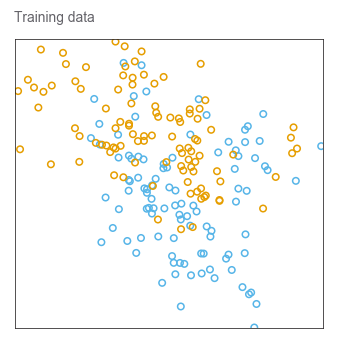

In [5]:
# draws training samples scatter plot with title
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, facecolors='none',
               edgecolors=np.array([BLUE, ORANGE])[y_train])
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=GRAY4, fontsize=9)
    for spine_name in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine_name].set_color(GRAY1)
    return fig, ax

# test it
_, _ = plot_train_data('Training data')

In [6]:
# given a model prediction function, it computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function, it computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(n1, n2, predict):
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function, it plots train data, model decision
# bounary (by it's predict function) and background points
def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot decision boundary
    X0, X1, Y = fill_prediction_meshgrid(1000, 1000, predict)
    ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
    return fig, ax

## Optimal Bayes

In [7]:
# let's build an optimal Bayes classifier based on known means and convariances
def optimal_bayes_predict(X):
    cov = np.eye(2)/5
    # convert means to frozen random variables for pdf calculation
    blue_rvs = [multivariate_normal(blue_means[i], cov) for i in range(10)]
    orange_rvs = [multivariate_normal(orange_means[i], cov) for i in range(10)]
    p_blue = np.sum(np.array([rv.pdf(X) for rv in blue_rvs]), axis=0)
    p_orange = np.sum(np.array([rv.pdf(X) for rv in orange_rvs]), axis=0)
    y_hat = 1*(p_orange > p_blue)
    return y_hat

In [8]:
# calculate the optimal Bayes error rate on the test data
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


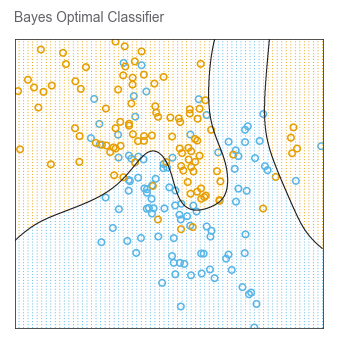

In [9]:
# plot optimal Bayes decision boundary
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

<h2>More Plotting Functions</h2>

In [10]:
# save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = fill_prediction_meshgrid(
    1000, 1000, optimal_bayes_predict)


# given a model prediction function, it plots the model's performance stat
def plot_model_stat(predict, title):
    fig, ax = plot_model(predict, title)
    ax.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple',
               linewidths=[0.5], linestyles='dashed')
    test_error_rate = 1 - accuracy_score(y_test, predict(X_test))
    train_error_rate = 1 - accuracy_score(y_train, predict(X_train))
    parms = {'color': GRAY1, 'fontsize': 7,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    ax.text(-2.42, -1.35, f'Training Error: {train_error_rate:.3f}', **parms)
    ax.text(-2.42, -1.62, f'Test Error:       {test_error_rate:.3f}', **parms)
    ax.text(-2.42, -1.89, f'Bayes Error:    {bayes_error_rate:.3f}', **parms)
    return fig, ax

<h2>Linear Regression</h2>

In [11]:
from sklearn.linear_model import LinearRegression

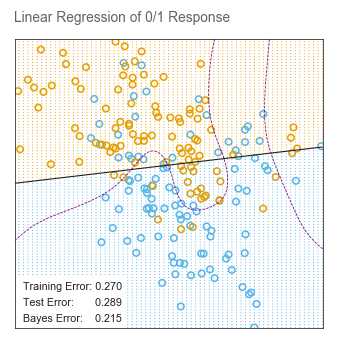

In [12]:
# PAGE 12. Let’s look at an example of the linear model in a classiﬁcation
#          context.
reg = LinearRegression().fit(X_train, y_train)


# PAGE 12. The ﬁtted values Y-hat are converted to a ﬁtted class variable G-hat
#          according to the rule G-hat = (ORANGE if Y-hat > 0.5, BLUE if
#          Y-hat ≤ 0.5.
def linear_predict(X):
    return 1*(reg.predict(X) > 0.5)

# PAGE 13. The line is the decision boundary deﬁned by x.T @ b = 0.5. The
#          orange shaded region denotes that part of input space classiﬁed as
#          ORANGE, while the blue region is classiﬁed as BLUE.
_, _ = plot_model_stat(linear_predict, 'Linear Regression of 0/1 Response')

<h2>Nearest-Neighbor Methods</h2>

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [14]:
# run GridSearchCV to find the best n_neighbors parameter using 10-folds CV
grid_search = GridSearchCV(
    KNeighborsClassifier(), {'n_neighbors': list(range(1, 50))}, cv=10
).fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 12}

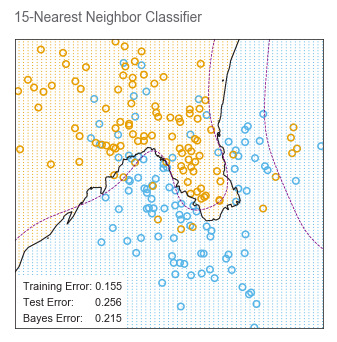

In [15]:
# PAGE 14. Use 15-nearest-neighbor averaging of the binary coded response as
#          the method of ﬁtting. Thus Y-hat is the proportion of ORANGE’s in
#          the neighborhood, and so assigning class ORANGE to G-hat if
#          Y-hat>0.5 amounts to a majority vote in the neighborhood.
knc = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)
_, _ = plot_model_stat(knc.predict, '15-Nearest Neighbor Classifier')

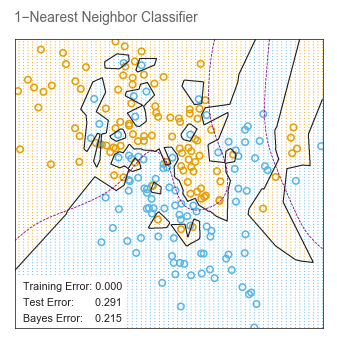

In [16]:
# PAGE 16. The classes are coded as a binary variable (BLUE = 0,ORANGE = 1),
#          and then predicted by 1-nearest-neighbor classiﬁcation.
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
_, _ = plot_model_stat(knc.predict, '1−Nearest Neighbor Classifier')

## Logistic Regression over Natural Cubic Splines

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
# I did not find a natural cubic spline basis expansion implementation for
# Pyhon, so let's implement it ourselves
class NaturalCubicSplineFeatures():
    def __init__(self, knots, tensor_product=False):
        self.knots = knots
        self.tensor_product = tensor_product

    def dk(self, x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)

    def do_nc_expansion(self, x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                dk1 = self.dk(x[i], xis[k-2], xis[-1])
                dk2 = self.dk(x[i], xis[-2], xis[-1])
                X[i, k] = dk1 - dk2
        return X

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            expansion = self.do_nc_expansion(X[:, i], self.knots[i])[:, 1:]
            h.append(expansion)
        if self.tensor_product:
            for j in range(h[0].shape[1]):
                for k in range(h[1].shape[1]):
                    h.append(h[0][:, j:j+1]*h[1][:, k:k+1])
        result = np.hstack(h)
        return result

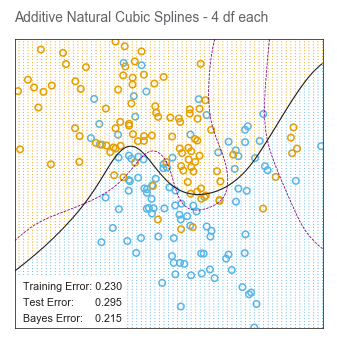

In [19]:
# place knots for natrual cubic splines
knots = np.array([-2, 0, 1, 3])
# PAGE 164. The upper panel shows the decision boundary of an additive logistic
#           regression model, using natural splines in each of the two
#           coordinates (total df = 1 + (4−1) + (4−1) = 7).
model = Pipeline([('expand', NaturalCubicSplineFeatures([knots, knots])),
                  ('scale', StandardScaler()),
                  ('logistic', LogisticRegression(C=1000, solver='lbfgs'))])
lrc = model.fit(X_train, y_train)
_, _ = plot_model_stat(
    lrc.predict, 'Additive Natural Cubic Splines - 4 df each')

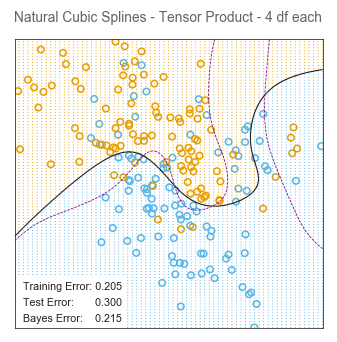

In [20]:
# PAGE 164. The lower panel shows the results of using a tensor product of
#           natural spline bases in each coordinate (total df = 4 × 4 = 16).
lrc = Pipeline([
    ('exp', NaturalCubicSplineFeatures([knots, knots], tensor_product=True)),
    ('scale', StandardScaler()),
    ('logistic', LogisticRegression(C=10000, solver='lbfgs'))]
).fit(X_train, y_train)
_, _ = plot_model_stat(
    lrc.predict, 'Natural Cubic Splines - Tensor Product - 4 df each')

<h2>Neural Networks</h2>

In [21]:
import tensorflow as tf
import math
from sklearn.preprocessing import OneHotEncoder

In [22]:
# PAGE 398. Since the scaling of the inputs determines the eﬀective scaling of
#           the weights in the bottom layer, it can have a large eﬀect on the
#           quality of the ﬁnal solution. At the outset it is best to
#           standardize all inputs to have mean zero and standard deviation
#           one. This ensures all inputs are treated equally in the
#           regularization process, and allows one to choose a meaningful range
#           for the random starting weights.
scaler = StandardScaler().fit(X_train)
X_train_standartized = scaler.transform(X_train)

# PAGE 392. For K-class classiﬁcation, there are K units at the top, with the
#           kth unit modeling the probability of class k. There are K target
#           measurements Yk, k = 1,...,K, each being coded as a 0−1 variable
#           for the kth class.
Y_train_one_hot = OneHotEncoder(
    categories='auto'
).fit_transform(np.atleast_2d(y_train).T).toarray()

In [23]:
session = tf.Session()

In [24]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer(seed=1)

x = tf.placeholder(tf.float64, shape=[None, 2])
y = tf.placeholder(tf.float64, shape=[None, 2])

A = tf.Variable(initializer([2, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 2], dtype=tf.float64))
b0 = tf.Variable(initializer([2], dtype=tf.float64))

# PAGE 392. Derived features Zm are created from linear combinations of the
#           inputs, and then the target Yk is modeled as a function of linear
#           combinations of the Zm, The activation function σ(v) is usually
#           chosen to be the sigmoid σ(v) = 1/(1+e−v);
Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

# PAGE 393. The output function gk(T) allows a ﬁnal transformation of the
#           vector of outputs T. For regression we typically choose the
#           identity function gk(T) = Tk. Early work in K-class classiﬁcation
#           also used the identity function, but this was later abandoned in
#           favor of the softmax function
y_hat = tf.nn.softmax(T)

# PAGE 395. For classiﬁcation we use either squared error or cross-entropy
#           (deviance)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))

In [25]:
feed_dict = {x: X_train_standartized, y: Y_train_one_hot}

In [26]:
# PAGE 395. The generic approach to minimizing R(θ) is by gradient descent,
#           called back-propagation in this setting. Because of the
#           compositional form of the model, the gradient can be easily derived
#           using the chain rule for diﬀerentiation. This can be computed by a
#           forward and backward sweep over the network, keeping track only of
#           quantities local to each unit.
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

# PAGE 395. Typically we don’t want the global minimizer of R(θ), as this is
#           likely to be an overﬁt solution. Instead some regularization is
#           needed: this is achieved directly through a penalty term, or
#           indirectly by early stopping.
admW = tf.contrib.opt.AdamWOptimizer(0.0028, learning_rate=1e-2).minimize(loss)

In [27]:
# let's write a generic training procedure
def train_and_plot(optimizer_step, title):
    session.run(tf.global_variables_initializer())
    step = 0
    # calc initial loss
    current_loss = session.run(loss, feed_dict)
    while step < 20000:
        step += 1
        if math.log(step, 5).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(optimizer_step, feed_dict)
        current_loss = session.run(loss, feed_dict)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

    def nn_predict(X):
        X = scaler.transform(X)
        # PAGE 395. and the corresponding classiﬁer is G(x) = argmaxkfk(x)
        return np.argmax(session.run(y_hat, {x: X}), axis=1)

    plot_model_stat(nn_predict, title)

step: 1, current loss: 0.8709270406577174
step: 5, current loss: 0.7387966915270799
step: 25, current loss: 0.6051715552948866
step: 625, current loss: 0.48102861245398204
step: 3125, current loss: 0.3161895310120569
ENDED ON STEP: 20000, FINAL LOSS: 0.24605821505460163
step: 1, current loss: 0.7087873115952747
step: 5, current loss: 0.6879956127880382
step: 25, current loss: 0.6116854661040557
step: 625, current loss: 0.44855221724390615
step: 3125, current loss: 0.4164678434292311
ENDED ON STEP: 20000, FINAL LOSS: 0.37648124617296835


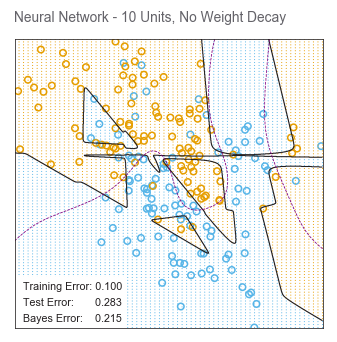

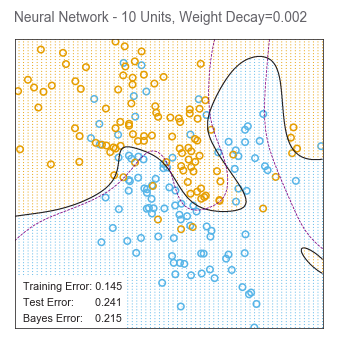

In [28]:
# PAGE 399. A neural network on the mixture example of Chapter 2. The upper
#           panel uses no weight decay, and overﬁts the training data. The
#           lower panel uses weight decay, and achieves close to the Bayes
#           error rate (broken purple boundary). Both use the softmax
#           activation function and cross-entropy error.
train_and_plot(adm, 'Neural Network - 10 Units, No Weight Decay')
train_and_plot(admW, 'Neural Network - 10 Units, Weight Decay=0.002')

## Support Vector Machines

In [29]:
from sklearn.svm import SVC

In [30]:
# common function for plotting SVC model
def plot_svc_model(svc, title):
    sv = abs(svc.decision_function(svc.support_vectors_))
    v = svc.support_vectors_[(sv > 0.99) & (sv < 1.01)]
    fig, ax = plot_model_stat(svc.predict, title)
    X0, X1, Y = fill_prediction_meshgrid(1000, 1000, svc.decision_function)
    ax.contour(X0, X1, Y, [-1, 1], colors=GRAY1, linewidths=[0.5, 0.5],
               linestyles='dashed')
    ax.scatter(v[:, 0], v[:, 1], c='black', s=10)

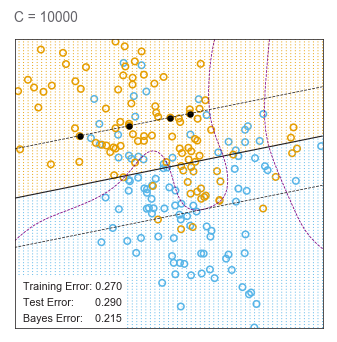

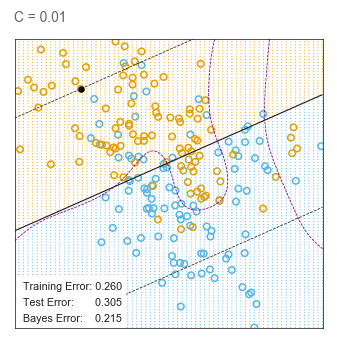

In [31]:
# PAGE 422. The linear support vector boundary for the mixture data example
#           with two overlapping classes, for two diﬀerent values of C.
#           The broken lines indicate the margins, where f(x) = ±1. The support
#           points (αi > 0) are all the points on the wrong side of their
#           margin.
svc = SVC(C=10000, kernel='linear')
svc.fit(X_train, y_train)
plot_svc_model(svc, 'C = 10000')

# PAGE 422. In the upper panel 62% of the observations are support points,
#           while in the lower panel 85% are.
svc = SVC(C=0.01, kernel='linear')
svc.fit(X_train, y_train)

# PAGE 421.  The margin is larger for C = 0.01 than it is for C = 10,000. Hence
#            larger values of C focus attention more on (correctly classiﬁed)
#            points near the decision boundary, while smaller values involve
#            data further away. Either way, misclassiﬁed points are given
#            weight, no matter how far away. In this example the procedure is
#            not very sensitive to choices of C, because of the rigidity of a
#            linear boundary.
plot_svc_model(svc, 'C = 0.01')

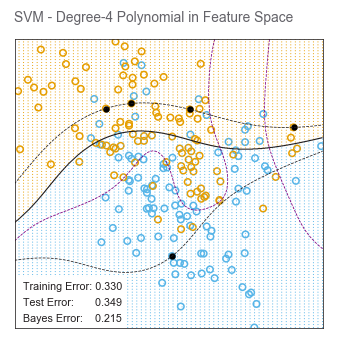

In [32]:
# the result for poly 4 looks bad
svc = SVC(kernel='poly', degree=3, C=1)
svc.fit(X_train, y_train)
plot_svc_model(svc, 'SVM - Degree-4 Polynomial in Feature Space')

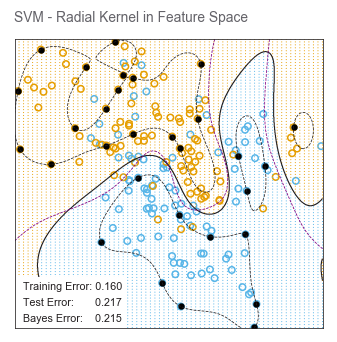

In [33]:
svc = SVC(kernel='rbf', gamma=1)
svc.fit(X_train, y_train)
plot_svc_model(svc, 'SVM - Radial Kernel in Feature Space')

## FDA/MARS & MDA
I have not found the flexible discriminant analysis implementation for Python. Implemented it myself. The result is close to the values from the book, but slightly worse. Maybe I made some mistakes. More research and testing is needed. The approch is explained here https://www.researchgate.net/publication/2889611_Flexible_Discriminant_Analysis_by_Optimal_Scoring.

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.multiclass import unique_labels
from pyearth import Earth

In [35]:
# let's implement our flexible discriminant classifier
class FlexibleDiscriminantAnalysis():
    def __init__(self, model, n_components=None):
        self.model = model
        self.n_components = n_components

    def fit(self, X, y):
        _, counts_elements = np.unique(y, return_counts=True)
        priors = counts_elements/y.shape[0]
        # PAGE 440. We create an N × K indicator response matrix Y
        Y = OneHotEncoder(
            categories='auto'
        ).fit_transform(np.atleast_2d(y).T).toarray()

        # PAGE 441. Multivariate nonparametric regression. Fit a multiresponse,
        #           adaptive nonparametric regression of Y on X
        self.model.fit(X, Y)

        # PAGE 441. Optimal scores. Compute the eigen-decomposition of
        #           Y.T @ Y_hat
        X_exp = self.model.transform(X)
        self.B = self.model.coef_.T
        evals, evecs = np.linalg.eig(Y.T @ (X_exp @ self.B))
        evals_ord = np.argsort(evals)[::-1]
        evals = evals[evals_ord]
        evecs = evecs[:, evals_ord]
        O = evecs
        O /= np.sqrt(np.diagonal(O.T @ np.diag(priors) @ O))

        # PAGE 441. Update the model from step 1 using the optimal scores.
        self.B = self.B @ O
        R = self.transform(X)
        self.lda = LinearDiscriminantAnalysis().fit(R, y)
        return self

    def transform(self, X):
        X_exp = self.model.transform(X)
        R = (self.B.T @ X_exp.T).T
        if self.n_components is None:
            return R
        return R[:, :self.n_components]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def predict(self, X):
        R = self.transform(X)
        return self.lda.predict(R)

In [36]:
fda = FlexibleDiscriminantAnalysis(
    Earth(max_terms=19, max_degree=2, enable_pruning=False)
).fit(X_train, y_train)

In [37]:
# PAGE 449. Linear discriminant analysis can be viewed as a prototype
#           classifier. Each class is represented by its centroid, and we
#           classify to the closest using an appropriate metric. In many
#           situations a single prototype is not sufficient to represent
#           inhomogeneous classes, and mixture models are more appropriate.
class MixtureDiscriminantAnalysis():
    def __init__(self, n_prototypes, max_steps=100, random_state=0):
        self.n_prototypes = n_prototypes
        self.random_state = random_state
        self.max_steps = max_steps

    def fit(self, X, y):
        N, p = X.shape[0], X.shape[1]
        self.classes_ = unique_labels(y)
        _, y_t = np.unique(y, return_inverse=True)
        self.priors_ = np.bincount(y_t) / float(len(y))
        # set initial random means for each prototype
        np.random.seed(self.random_state)
        means = np.stack(
            [np.vstack([np.quantile(X[y == k][:, i],
                                    np.random.uniform(0, 1, self.n_prototypes))
                        for i in range(p)]).T
             for k in self.classes_])
        # assign each observation to the closest class prototype
        # and calculate mixin proportions
        y_r = np.zeros(shape=N, dtype=int)
        for i in range(N):
            y_r[i] = np.argmin(np.sum((means[y[i]] - X[i])**2, axis=1))
        mixin_proportions = np.stack(
            [np.bincount(y_r[y == k]) / np.sum(y == k)
             for k in self.classes_])
        # calculate init covariance matrix based on hard prototype assignment
        cov = np.zeros(shape=(p, p))
        for k in self.classes_:
            for r in range(self.n_prototypes):
                Xkr = X[(y == k) & (y_r == r), :]
                cov += mixin_proportions[k, r] * \
                       self.priors_[k] * np.cov(Xkr.T, bias=1)

        # do Expectation-Maximization
        for step in range(self.max_steps):
            # PAGE 450. E-step: Given the current parameters, compute the
            #           responsibility of subclass ckr within class k for each
            #           of the class-k observations (gi = k): (12.62)
            resp = np.zeros((N, self.n_prototypes))
            for i in range(N):
                k = y[i]
                for r in range(self.n_prototypes):
                    prob = multivariate_normal.pdf(X[i], means[k, r], cov)
                    resp[i, r] = mixin_proportions[k, r] * prob
                resp[i, :] /= np.sum(resp[i])
            # PAGE 450. M-step: Compute the weighted MLEs for the parameters of
            #           each of the component Gaussians within each of the
            #           classes, using the weights from the E-step.
            for k in self.classes_:
                Xk = X[y == k]
                respk = resp[y == k]
                for r in range(self.n_prototypes):
                    respkr = respk[:, r]
                    mixin_proportions[k, r] = np.sum(respkr)/Xk.shape[0]
                    tmp = np.vstack((respkr, respkr)).T
                    means[k, r] = np.sum(Xk*tmp, axis=0)/np.sum(respkr)

            cov = np.zeros(shape=(p, p))
            for i in range(N):
                k = y[i]
                for r in range(self.n_prototypes):
                    v = np.atleast_2d(X[i] - means[k, r]).T
                    cov += resp[i, r]*(v @ v.T)
            cov /= N

        self.means_ = means
        self.mixin_proportions_ = mixin_proportions
        self.cov_ = cov

        return self

    def predict_proba(self, X):
        # PAGE 449. Given such a model for each class, the class
        #           posterior probabilities are given by (12.60)
        prot_probs = np.zeros(
            (X.shape[0], len(self.classes_), self.n_prototypes))
        for k in self.classes_:
            pk = self.priors_[k]
            for r in range(self.n_prototypes):
                mpkr = self.mixin_proportions_[k, r]
                prob = mpkr * multivariate_normal.pdf(
                    X, self.means_[k, r], self.cov_) * pk
                prot_probs[:, k, r] = prob

        k_probs = np.sum(prot_probs, axis=2)
        den = np.sum(k_probs, axis=1)
        result = k_probs/np.vstack((den, den)).T
        return result

    def predict(self, X):
        result = np.argmax(self.predict_proba(X), axis=1)
        return result

In [38]:
mda = MixtureDiscriminantAnalysis(5, 100, 30).fit(X_train, y_train)

In [34]:
# draws model detailed plot and adds blue and orange prototypes to it
def plot_prototypes_model(predict, title, blue_prototypes, orange_prototypes):
    fig, ax = plot_model_stat(predict, title)
    ax.scatter(blue_prototypes[:, 0], blue_prototypes[:, 1],
               s=50, facecolors=BLUE, edgecolors='black')
    ax.scatter(orange_prototypes[:, 0], orange_prototypes[:, 1],
               s=50, facecolors=ORANGE, edgecolors='black')    

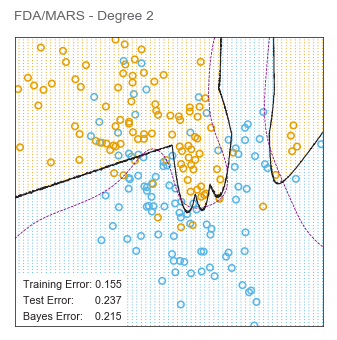

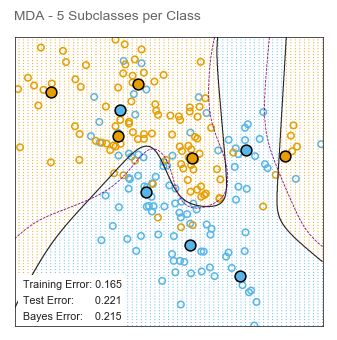

In [40]:
# PAGE 452. FIGURE 12.13. FDA and MDA on the mixture data. The upper plot uses
#           FDA with MARS as the regression procedure. The lower plot uses MDA
#           with five mixture centers per class (indicated). The MDA solution
#           is close to Bayes optimal, as might be expected given the data
#           arise from mixtures of Gaussians. The broken purple curve in the
#           background is the Bayes decision boundary
_, _ = plot_model_stat(fda.predict, 'FDA/MARS - Degree 2')
plot_prototypes_model(
    mda.predict, 'MDA - 5 Subclasses per Class',
    mda.means_[0], mda.means_[1])

## Prototypes and Nearest-Neighbors

In [35]:
from sklearn.cluster import KMeans

In [36]:
# PAGE 460. To use K-means clustering for classification of labeled data, the
#           steps are:
#           - apply K-means clustering to the training data in each class
#             separately, using R prototypes per class;
#           - assign a class label to each of the K x R prototypes;
#           - classify a new feature x to the class of the closest prototype.
kmeans_blue = KMeans(n_clusters=5).fit(X_test[y_test == 0])
kmeans_orange = KMeans(n_clusters=5).fit(X_test[y_test == 1])

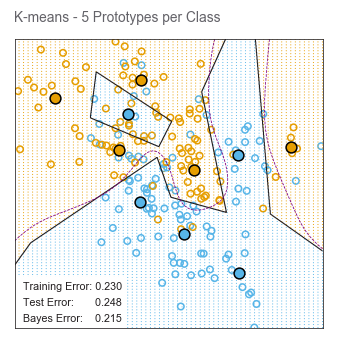

In [37]:
def k_means_predict(X):
    return np.argmin(np.vstack((np.min(kmeans_blue.transform(X), axis=1),
                                np.min(kmeans_orange.transform(X), axis=1))).T,
                     axis=1)


# PAGE 464. The upper panel shows the K-means classifier applied to the mixture
#           data example. The decision boundary is piecewise linear.
plot_prototypes_model(
    k_means_predict, 'K-means - 5 Prototypes per Class',
    kmeans_blue.cluster_centers_, kmeans_orange.cluster_centers_)

In [38]:
# PAGE 463. As a consequence, the Gaussian mixture model is ofthen referred to
#           as a soft clustering method, while K-means is hard.
gm_blue = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=3
).fit(X_test[y_test == 0])
gm_orange = GaussianMixture(
    n_components=5, covariance_type='spherical', random_state=3
).fit(X_test[y_test == 1])

In [39]:
def gaussian_mixture_predict(X):
    blue_rvs = [(gm_blue.weights_[i],
                 multivariate_normal(gm_blue.means_[i],
                                     gm_blue.covariances_[i]))
                for i in range(5)]
    orange_rvs = [(gm_orange.weights_[i],
                   multivariate_normal(gm_orange.means_[i],
                                       gm_orange.covariances_[i]))
                  for i in range(5)]
    p_blue = np.sum(
        np.array([rv[0] * rv[1].pdf(X) for rv in blue_rvs]), axis=0)
    p_orange = np.sum(
        np.array([rv[0] * rv[1].pdf(X) for rv in orange_rvs]), axis=0)
    y_hat = 1*(p_orange > p_blue)
    return y_hat

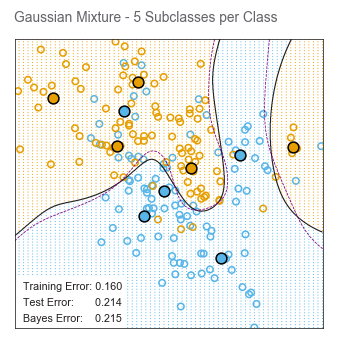

In [40]:
# PAGE 464. The lower panel shows a Gaussian mixture model with a common
#           covariance for all component Gaussians. The EM algorithm for the
#           mixture model was started at the K-means solution.
plot_prototypes_model(
    gaussian_mixture_predict, 'Gaussian Mixture - 5 Subclasses per Class',
    gm_blue.means_, gm_orange.means_)

## k-Nearest-Neighbor Classifiers

In [41]:
n_neighbors_vals = list(range(1, 30, 2))
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': n_neighbors_vals},
    cv=10, scoring='accuracy', return_train_score=True, iid=True
).fit(X_train, y_train)

train_errors, test_errors = [], []
for k in n_neighbors_vals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_errors.append(1 - accuracy_score(y_train, clf.predict(X_train)))
    test_errors.append(1 - accuracy_score(y_test, clf.predict(X_test)))

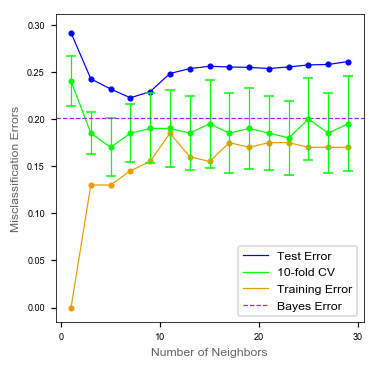

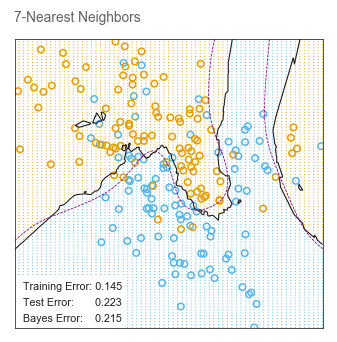

In [42]:
# PAGE 467. k-nearest-neighbors on the two-class mixture data. The upper
#           panel shows the misclassification errors as a function of
#           neighborhood size. Standard error bars are included for 10-fold
#           cross validation. The lower panel shows the decision boundary
#           for 7-nearest-neighbors, which appears to be optimal for minimizing
#           test error.
cv_erros = 1 - np.vstack([grid_search.cv_results_[f'split{i}_test_score']
                          for i in range(10)]).T
cv_mean_errors = np.mean(cv_erros, axis=1)
cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(10)
best_index = np.argmin(cv_mean_errors)
best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]

fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neighbors_vals, test_errors, c='#0000FF', s=9)
ax.plot(n_neighbors_vals, test_errors, c='#0000FF', linewidth=0.8,
        label='Test Error')
ax.plot(n_neighbors_vals, cv_mean_errors, c='#00FF00', linewidth=0.8,
        label='10-fold CV')
ax.scatter(n_neighbors_vals, train_errors, c=ORANGE, s=9)
ax.plot(n_neighbors_vals, train_errors, c=ORANGE, linewidth=0.8,
        label='Training Error')

ax.errorbar(n_neighbors_vals, cv_mean_errors,
            color='#00FF00', linestyle='None', marker='o', elinewidth=0.8,
            markersize=3, yerr=cv_std_errors, ecolor='#00FF00', capsize=3)
ax.axhline(y=best_err+best_std_err, c=PURPLE, linewidth=0.8, linestyle='--',
           label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.set_xlabel('Number of Neighbors', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Errors', color=GRAY4, fontsize=8)

knc = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
plot_model_stat(knc.predict, '7-Nearest Neighbors')
_ = ax.legend(loc='bottom right', prop={'size': 8})

## Random Forests

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS

In [44]:
rfc = RandomForestClassifier(
    n_estimators=35,
    random_state=0,
    oob_score=True
).fit(X_train, y_train)
knc = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

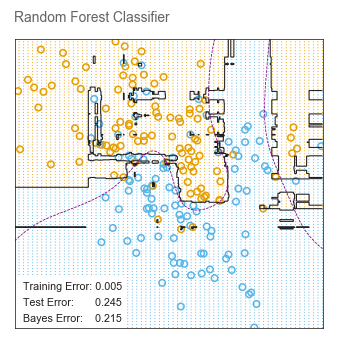

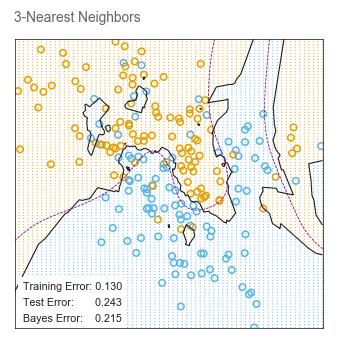

In [45]:
# PAGE 602. FIGURE 15.11 Random forests versus 3-NN on the mixture data. The
#           axis-oriented nature of the individual trees in a random forest
#           lead to decision regions with an axis-oriented flavor.
plot_model_stat(rfc.predict, 'Random Forest Classifier')
_, _ = plot_model_stat(knc.predict, '3-Nearest Neighbors')

In [46]:
# PAGE 595. In growing a random forest, an NxN proximity matrix is accumulated
#           for the training data. For every tree, any pair of OOB observations
#           sharing a terminal node has their proximity increased by one.
# my approach is slightly incorrect, because we should use
# out-of-bag observations only, but I don't know how to get it
leaf_ids = rfc.apply(X_train)
N = X_train.shape[0]
proximity_matrix = np.zeros((N, N))
for i in range(leaf_ids.shape[1]):
    tree_leaf_ids = leaf_ids[:, i]
    proximity_matrix += np.equal.outer(tree_leaf_ids, tree_leaf_ids)
proximity_matrix /= leaf_ids.shape[1]

In [47]:
# PAGE 595. This proximity matrix is then represented in two dimensions using
#           multidimensional scaling (Secion 14.8). The idea is that even
#           though the data may be high-dimensional, involving mixed variables,
#           etc., the proximity plot gives and indication of which observations
#           are effectively close together in the eyes of the random forest
#           classifier.
mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=1
).fit_transform(1 - proximity_matrix)
centers = KMeans(n_clusters=6).fit(mds).cluster_centers_
closest_idx = [np.argmin(np.sum((mds - centers[i])**2, axis=1))
               for i in range(6)]
mds_points = mds[closest_idx]
obs_points = X_train[closest_idx]

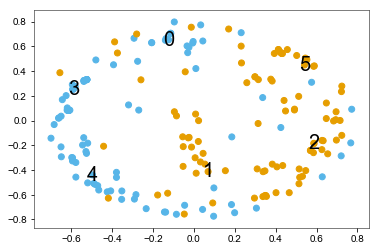

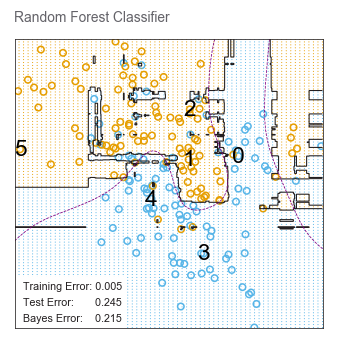

In [48]:
# PAGE 595. FIGURE 15.6. (Left): Proximity plot for a random forest classifier
#           grown to the mixture data. (Right): Decision boundary and training
#           data for random forest on mixture data. Six points have been
#           identified in each plot.
plt.scatter(mds[:, 0], mds[:, 1], c=np.array([BLUE, ORANGE])[y_train])
for i in range(6):
    plt.annotate(f'{i}', mds_points[i], ha='center', va='center',
                 color='black', fontsize=20)

fig, ax = plot_model_stat(rfc.predict, 'Random Forest Classifier')
for i in range(6):
    ax.annotate(f'{i}', obs_points[i], ha='center', va='center',
                color='black', fontsize=15)